In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

import wandb
import logging
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Define constants and configurations
num_features = 7  # Number of features
sequence_length = 25
evaluation_interval = 168
mae_threshold = 0.1
ks_threshold = 0.05

In [3]:
# Load data
num_users = 3

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter data for a specific period
start_date = df.index.min() + pd.DateOffset(years=1)
end_date = start_date + pd.DateOffset(months=1)
#end_date = df.index.max()
df = df[(df.index >= start_date) & (df.index < end_date)]

df = min_max_scaling(df)
df.reset_index(inplace=True, drop=True)

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

In [4]:
loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

custom_objects = {
                'EinsumLayer': EinsumLayer,
                'TopKLayer': TopKLayer,
                'ImportanceRegularizationLayer': ImportanceRegularizationLayer
                }

In [9]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['User', 'Round', 
                                   'RMSE_BiLSTM', 'MAE_BiLSTM', 'MSE_BiLSTM', 
                                   'RMSE_CNN', 'MAE_CNN', 'MSE_CNN',
                                   'RMSE_Transformer', 'MAE_Transformer', 'MSE_Transformer', 
                                   'RMSE_soft_dense', 'MAE_soft_dense', 'MSE_soft_dense',
                                   'RMSE_soft_bilstm', 'MAE_soft_bilstm', 'MSE_soft_bilstm',
                                   'RMSE_topk_dense', 'MAE_topk_dense', 'MSE_topk_dense',
                                   'RMSE_topk_bilstm', 'MAE_topk_bilstm', 'MSE_topk_bilstm'])

num_rounds = 2
for round in range(num_rounds):
    for user_index, user_df in enumerate(df_array):

        # Load and compile models
        bilstm = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Benchmark\wandb\TS_LL_Grossload_bilstm'+f'_u{user_index+1}_rd{round+1}.keras', compile=False)
        bilstm.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

        cnn = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Benchmark\wandb\TS_LL_Grossload_cnn'+f'_u{user_index+1}_rd{round+1}.keras', compile=False)
        cnn.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

        transformer = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Benchmark\wandb\TS_LL_Grossload_transformer'+f'_u{user_index+1}_rd{round+1}.keras', compile=False)
        transformer.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
        
        soft_bilstm = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Moe\wandb\TS_LL_Grossload_lstm_soft_moe'+f'_u{user_index+1}_rd{round+1}.keras', custom_objects=custom_objects, compile=False)
        soft_bilstm.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

        soft_dense = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Moe\wandb\TS_LL_Grossload_dense_soft_moe'+f'_u{user_index+1}_rd{round+1}.keras', custom_objects=custom_objects, compile=False)
        soft_dense.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

        topk_bilstm = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Moe\wandb\TS_LL_Grossload_lstm_topk_moe'+f'_u{user_index+1}_rd{round+1}.keras', custom_objects=custom_objects, compile=False)
        topk_bilstm.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

        topk_dense = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Moe\wandb\TS_LL_Grossload_dense_topk_moe'+f'_u{user_index+1}_rd{round+1}.keras', custom_objects=custom_objects, compile=False)
        topk_dense.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
    
        
        # Stream data simulation, initialization
        stream_data = user_df.values
        stream_buffer = []
        stream_predictions_bilstm = []
        stream_predictions_cnn = []
        stream_predictions_transformer = []
        stream_predictions_soft_dense = []
        stream_predictions_soft_bilstm = []
        stream_predictions_topk_dense = []
        stream_predictions_topk_bilstm = []

        actual_values = []
        
        cd_mae_counter = 0
        cd_ks_counter = 0
        previous_mae_bilstm = np.NaN
        total_mae_bilstm = 0
    

        # Enumerate through the data stream
        for idx, data in enumerate(stream_data):
            
            # Buffer: Append data (1 row is one array) to the buffer and pop oldest if sequence_length is surpassed.
            stream_buffer.append(data)
            if len(stream_buffer) > sequence_length:
                # Remove the oldest data point to maintain the buffer size
                stream_buffer.pop(0)

            # Ensure the buffer is full (sequence_length = 25)
            if len(stream_buffer) == sequence_length:
                # Take the last 24 rows (each 7 features) to predict the 25th consumption value
                x_pred = np.array([stream_buffer[:-1]])  

                # Make a prediction, x_pred.shape = (1, 24, 8)
                prediction_bilstm = bilstm.predict(x_pred, callbacks=callbacks)
                prediction_cnn = cnn.predict(x_pred, callbacks=callbacks)
                prediction_transformer = transformer.predict(x_pred, callbacks=callbacks)

                prediction_soft_dense = soft_dense.predict(x_pred, callbacks=callbacks)
                prediction_soft_bilstm = soft_bilstm.predict(x_pred, callbacks=callbacks)
                prediction_topk_dense = topk_dense.predict(x_pred, callbacks=callbacks)
                prediction_topk_bilstm = topk_bilstm.predict(x_pred, callbacks=callbacks)

                # Append only the value (First row and first column)
                stream_predictions_bilstm.append(prediction_bilstm[0, 0])
                stream_predictions_cnn.append(prediction_cnn[0, 0])
                stream_predictions_transformer.append(prediction_transformer[0, 0])

                stream_predictions_soft_dense.append(prediction_soft_dense[0, 0])
                stream_predictions_soft_bilstm.append(prediction_soft_bilstm[0, 0])
                stream_predictions_topk_dense.append(prediction_topk_dense[0, 0])
                stream_predictions_topk_bilstm.append(prediction_topk_bilstm[0, 0])

                # Append actual value for later comparison
                actual = stream_buffer[-1][0]
                actual_values.append(actual)

                # Calculate MAE for the prediction using the 25th value (last row, first column)
    
                mae_bilstm = np.abs(actual - prediction_bilstm[0, 0])      
                total_mae_bilstm += mae_bilstm    
                
            # Check and evaluate at every evaluation_interval
            if (idx + 1) % evaluation_interval == 0:
                # Ensure we have enough predictions to compare
                if len(stream_predictions_bilstm) >= evaluation_interval:
                    # Calculate RMSE for the evaluation window
                    actual_values_evaluation = stream_data[idx+1-evaluation_interval:idx+1, 0]

                    predicted_values_bilstm = stream_predictions_bilstm[-evaluation_interval:]
                                    
                    # Check for concept drift using MAE
                    if not np.isnan(previous_mae_bilstm) and mae_bilstm > previous_mae_bilstm * (1 + mae_threshold):
                        cd_mae_counter += 1

                    # Check for concept drift using KS test
                    if ks_2samp(actual_values_evaluation, predicted_values_bilstm).statistic > ks_threshold:
                        cd_ks_counter += 1

                    # Update previous MAE
                    previous_mae_bilstm = total_mae_bilstm / evaluation_interval
                    total_mae_bilstm = 0
        
        # Calculate metrics for each model and append to DataFrame
        metrics = {
            'User': user_index+1,
            'Round' : round+1,
            'CD_mae_count' : cd_mae_counter,
            'CD_ks_count' : cd_ks_counter,
            'RMSE_BiLSTM': np.sqrt(mean_squared_error(actual_values, stream_predictions_bilstm)),
            'MAE_BiLSTM': mean_absolute_error(actual_values, stream_predictions_bilstm),
            'MSE_BiLSTM': mean_squared_error(actual_values, stream_predictions_bilstm),
            'RMSE_CNN': np.sqrt(mean_squared_error(actual_values, stream_predictions_cnn)),
            'MAE_CNN': mean_absolute_error(actual_values, stream_predictions_cnn),
            'MSE_CNN': mean_squared_error(actual_values, stream_predictions_cnn),
            'RMSE_Transformer': np.sqrt(mean_squared_error(actual_values, stream_predictions_transformer)),
            'MAE_Transformer': mean_absolute_error(actual_values, stream_predictions_transformer),
            'MSE_Transformer': mean_squared_error(actual_values, stream_predictions_transformer),
            'RMSE_soft_dense' : np.sqrt(mean_squared_error(actual_values, stream_predictions_soft_dense)), 
            'MAE_soft_dense' : mean_absolute_error(actual_values, stream_predictions_soft_dense), 
            'MSE_soft_dense': mean_squared_error(actual_values, stream_predictions_soft_dense),
            'RMSE_soft_bilstm': np.sqrt(mean_squared_error(actual_values, stream_predictions_soft_bilstm)),  
            'MAE_soft_bilstm' : mean_absolute_error(actual_values, stream_predictions_soft_bilstm),
            'MSE_soft_bilstm': mean_squared_error(actual_values, stream_predictions_soft_bilstm),
            'RMSE_topk_dense': np.sqrt(mean_squared_error(actual_values, stream_predictions_topk_dense)),  
            'MAE_topk_dense' : mean_absolute_error(actual_values, stream_predictions_topk_dense),
            'MSE_topk_dense': mean_squared_error(actual_values, stream_predictions_topk_dense),
            'RMSE_topk_bilstm': np.sqrt(mean_squared_error(actual_values, stream_predictions_topk_bilstm)),  
            'MAE_topk_bilstm' : mean_absolute_error(actual_values, stream_predictions_topk_bilstm),
            'MSE_topk_bilstm': mean_squared_error(actual_values, stream_predictions_topk_bilstm),
        }
        results_df.loc[len(results_df)] = metrics
   
print("Concept drift MAE: ", cd_mae_counter)
print("Concept drift Kolmogorov-Smirnov test: ", cd_ks_counter)
results_df  

1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

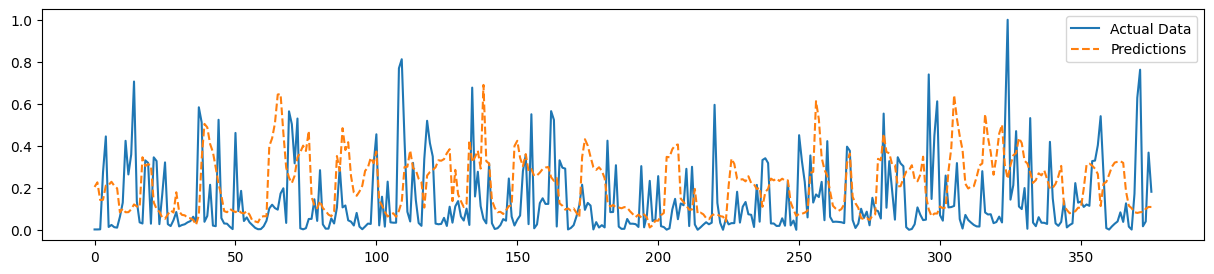

In [7]:
# Plotting to visualize the results
plt.figure(figsize=(15, 3))
plt.plot(df['User1'][124:500].values, label='Actual Data')
plt.plot(stream_predictions_topk_dense[124:500], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()